## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
import tweet_utility_preprocess_roberta_scripts_text as preprocess_text
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from scripts_step_lr_schedulers import *

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
# Unzip files
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/no_qa_fold_1.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/no_qa_fold_2.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/no_qa_fold_3.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/no_qa_fold_4.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/no_qa_fold_5.tar.gz

In [3]:
database_base_path = '/kaggle/input/tweet-dataset-5fold-roberta-base-96-complete/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,validation,train,train


# Model parameters

In [4]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  'MAX_LEN': 96,
  'BATCH_SIZE': 32,
  'EPOCHS': 4,
  'LEARNING_RATE': 3e-5,
  'ES_PATIENCE': 4,
  'N_FOLDS': 5,
  'base_model_path': base_path + 'roberta-base-tf_model.h5',
  'config_path': base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [5]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1e-06


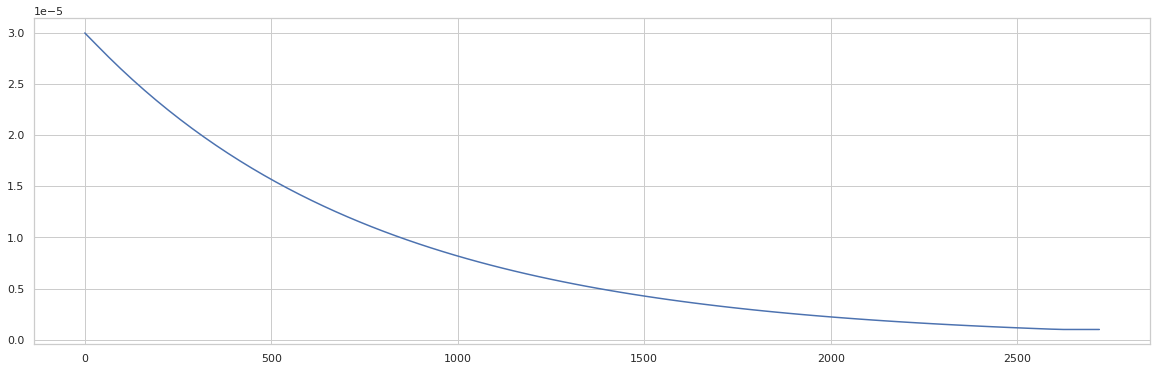

In [6]:
lr_min = 1e-6
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
decay = .9987

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=1, lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    input_sentiment = layers.Input(shape=(3,), dtype=tf.float32, name='input_sentiment')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x = layers.Dropout(.1)(last_hidden_state)
    
    x_start = layers.Dense(1)(x)
    x_start = layers.Flatten()(x_start)
    x_start = layers.Activation('softmax')(x_start)
    
    y_start_negative = layers.Multiply(name='y_start_negative')([x_start, input_sentiment[: ,0]])
    y_start_neutral = layers.Multiply(name='y_start_neutral')([x_start, input_sentiment[: ,1]])
    y_start_positive = layers.Multiply(name='y_start_positive')([x_start, input_sentiment[: ,2]])
    y_start = layers.Add(name='y_start')([y_start_negative, y_start_neutral, y_start_positive])
    
    x_end = layers.Dense(1)(x)
    x_end = layers.Flatten()(x_end)
    x_end = layers.Activation('softmax')(x_end)

    y_end_negative = layers.Multiply(name='y_end_negative')([x_end, input_sentiment[: ,0]])
    y_end_neutral = layers.Multiply(name='y_end_neutral')([x_end, input_sentiment[: ,1]])
    y_end_positive = layers.Multiply(name='y_end_positive')([x_end, input_sentiment[: ,2]])
    y_end = layers.Add(name='y_end')([y_end_negative, y_end_neutral, y_end_positive])
    
    model = Model(inputs=[input_ids, attention_mask, input_sentiment], outputs=[y_start, y_end])
    
    return model

# Train

In [8]:
def get_training_dataset(x_train, y_train, batch_size, buffer_size, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 'attention_mask': x_train[1], 'input_sentiment': x_train[2]}, 
                                                  {'y_start': y_train[0],'y_end': y_train[1]}))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 'attention_mask': x_valid[1], 'input_sentiment': x_valid[2]}, 
                                                  {'y_start': y_valid[0],'y_end': y_valid[1]}))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test[0], 'attention_mask': x_test[1], 'input_sentiment': x_test[2]})
    dataset = dataset.batch(batch_size)
    return dataset

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
k_fold_best = k_fold.copy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'no_qa_fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    x_train_aux2 = np.load(base_data_path + 'x_train_aux2.npy').astype(np.float32)
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    x_valid_aux2 = np.load(base_data_path + 'x_valid_aux2.npy').astype(np.float32)
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset((*x_train, x_train_aux2), y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset((*x_valid, x_valid_aux2), y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn(y['y_start'], probabilities[0], label_smoothing=0.2)
                loss_end = loss_fn(y['y_end'], probabilities[1], label_smoothing=0.2)
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn(y['y_start'], probabilities[0])
            loss_end = loss_fn(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=1, lr_start=lr_max, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    loss_fn = losses.categorical_crossentropy
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         model_path, save_last=True)
    
    history_list.append(history)
    
    # Make predictions (last model)
    x_train = np.load(base_data_path + 'x_train.npy')
    x_train_aux2 = np.load(base_data_path + 'x_train_aux2.npy').astype(np.float32)
    x_valid = np.load(base_data_path + 'x_valid.npy')
    x_valid_aux2 = np.load(base_data_path + 'x_valid_aux2.npy').astype(np.float32)
    predict_eval_df(k_fold, model, (*x_train, x_train_aux2), (*x_valid, x_valid_aux2), get_test_dataset, 
                    preprocess_text.decode, n_fold, tokenizer, config)

    # Make predictions (best model)
    model.load_weights(model_path)
    predict_eval_df(k_fold_best, model, (*x_train, x_train_aux2), (*x_valid, x_valid_aux2), get_test_dataset, 
                    preprocess_text.decode, n_fold, tokenizer, config)
    
    ### Delete data dir
    shutil.rmtree(base_data_path)


FOLD: 1
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 280.5s loss: 4.7923 loss_start: 2.3746 loss_end: 2.4177 val_loss: 2.4388 val_loss_start: 1.2185 val_loss_end: 1.2203
Saved model weights at "model_fold_1.h5"

EPOCH 2/4
time: 265.0s loss: 4.3993 loss_start: 2.1979 loss_end: 2.2013 val_loss: 2.3763 val_loss_start: 1.2115 val_loss_end: 1.1648
Saved model weights at "model_fold_1.h5"

EPOCH 3/4
time: 265.4s loss: 4.2988 loss_start: 2.1489 loss_end: 2.1499 val_loss: 2.3946 val_loss_start: 1.2017 val_loss_end: 1.1929

EPOCH 4/4
time: 263.9s loss: 4.2435 loss_start: 2.1278 loss_end: 2.1157 val_loss: 2.3675 val_loss_start: 1.2001 val_loss_end: 1.1675
Saved model weights at "model_fold_1.h5"
Training finished saved model weights at "last_model_fold_1.h5"

FOLD: 2
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 278.9s loss: 4.7218 loss_start: 2.3463 loss_end: 2.3755 val_loss: 2.4799 val_loss_start: 1.2699 val_loss_end: 1.2100
Saved model weights at "model_fold_2.

# Model loss graph

Fold: 1


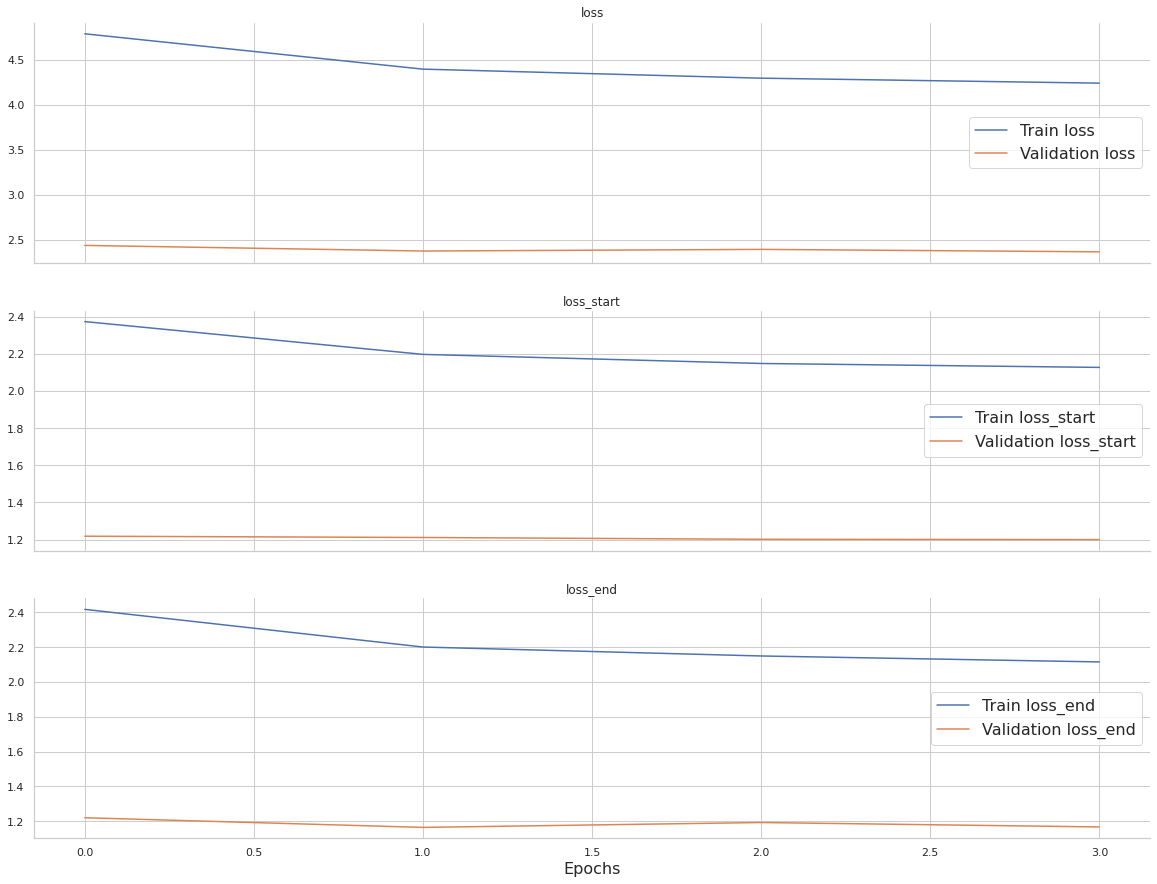

Fold: 2


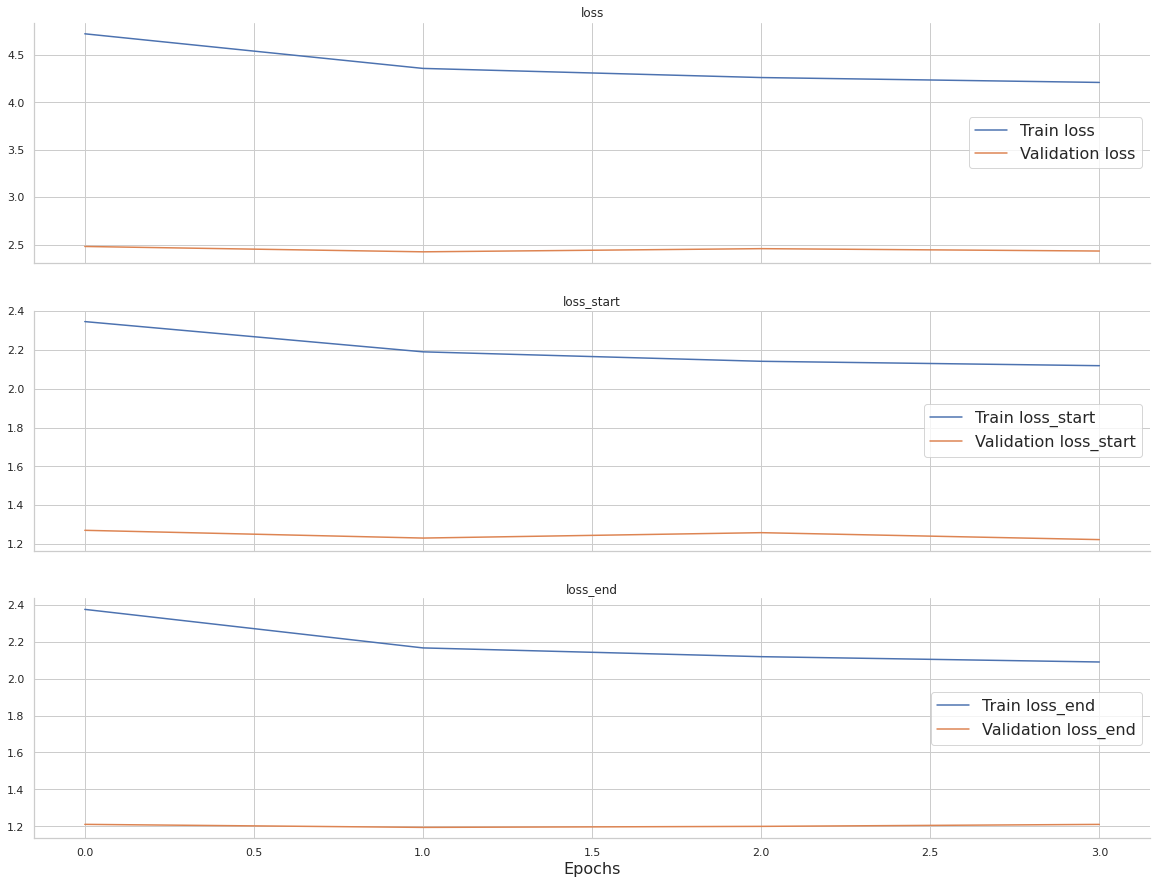

Fold: 3


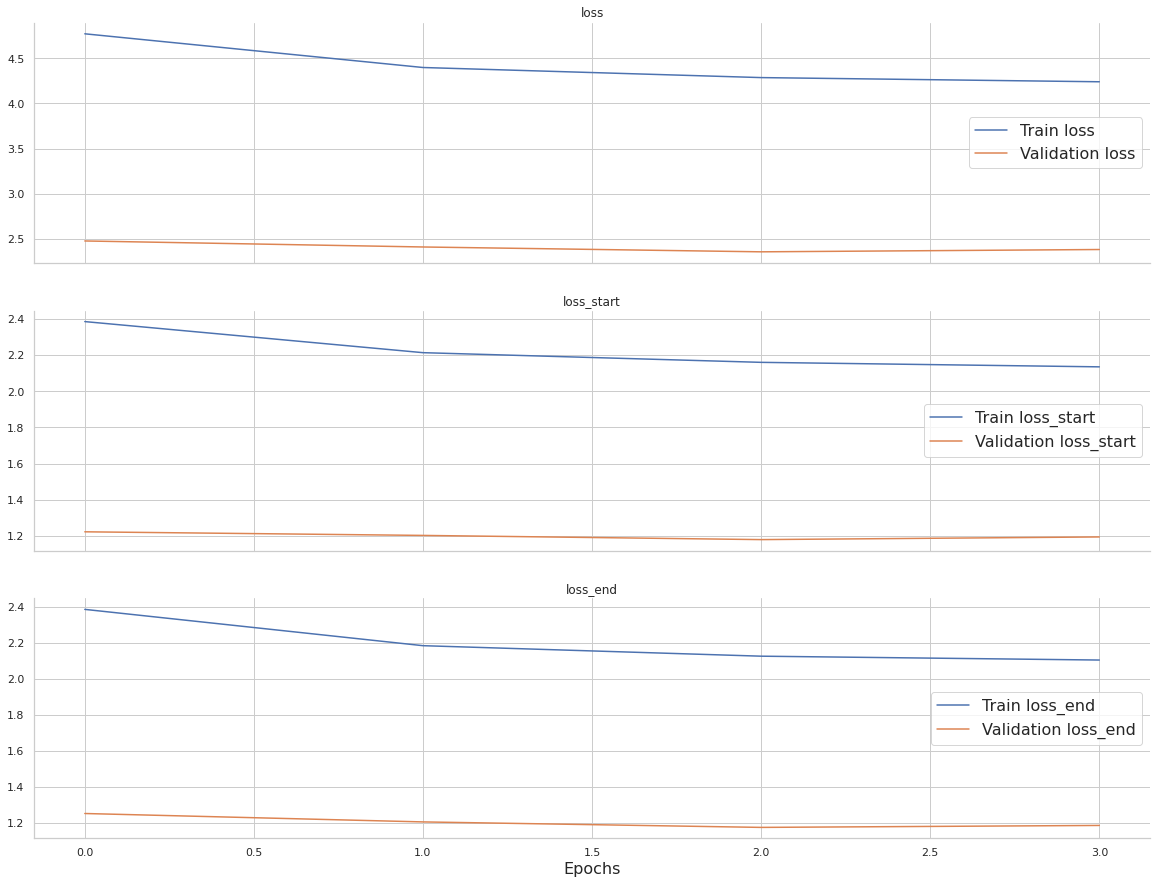

Fold: 4


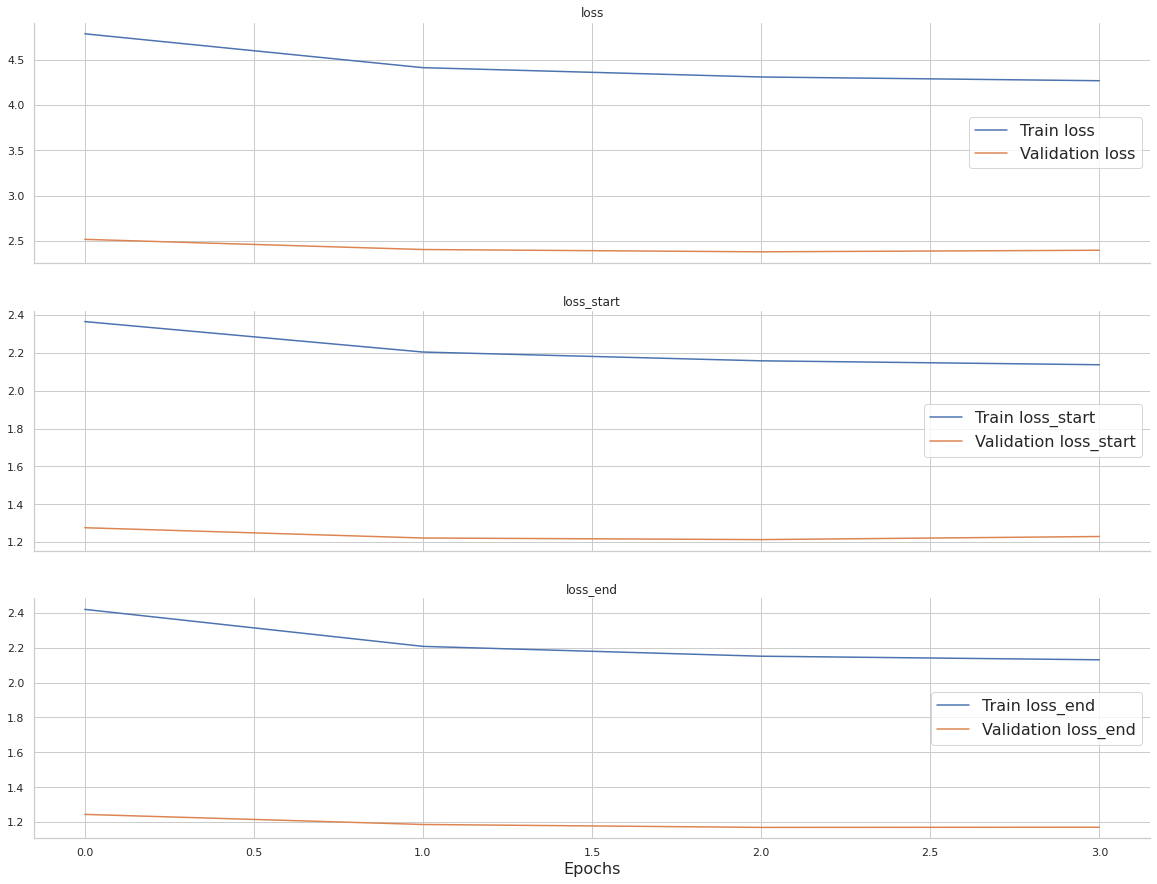

Fold: 5


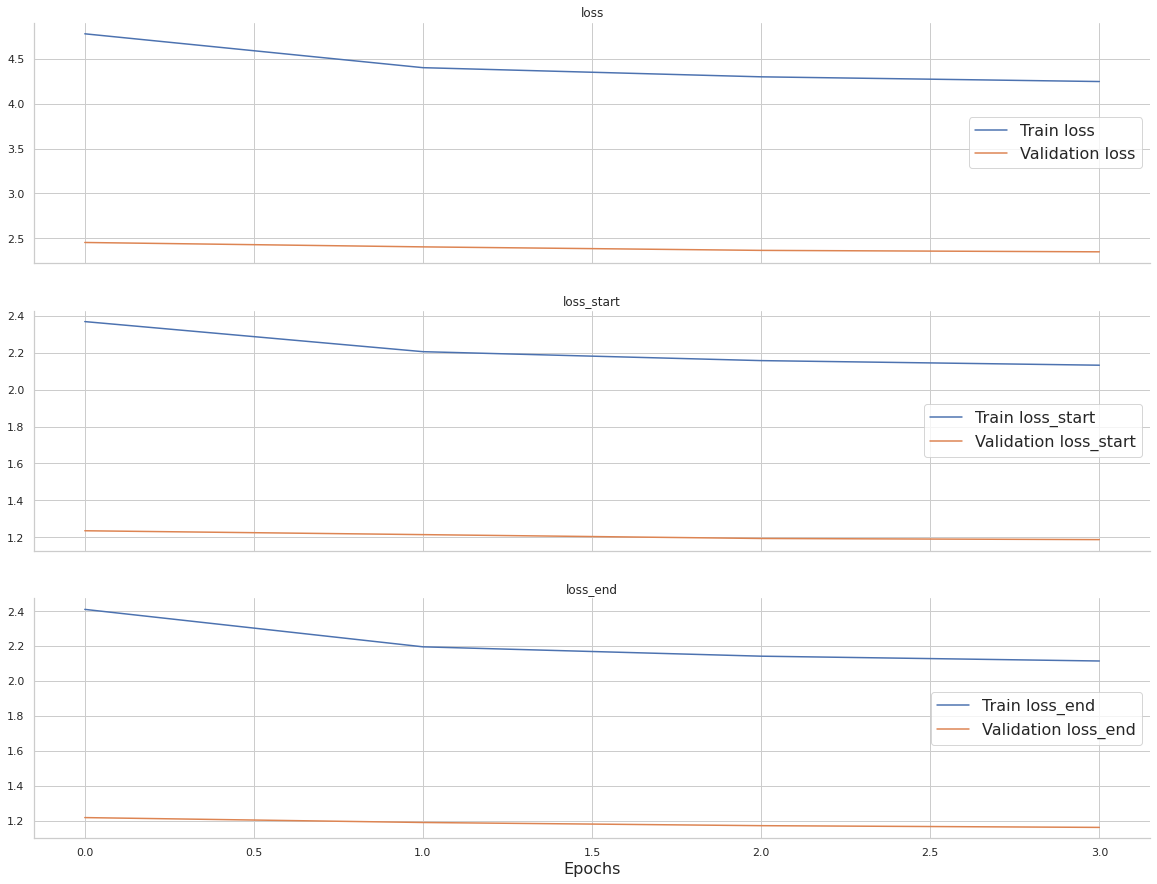

In [10]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation (last model)

In [11]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.665701,0.619699,0.046003,0.668230,0.619364,0.667104,0.618889,0.665804,0.622129,0.666677,0.612564,0.660691,0.625547
Sentiment negative,0.522845,0.464685,0.058159,0.527278,0.465408,0.531462,0.468232,0.516261,0.468710,0.524723,0.458106,0.514499,0.462972
Sentiment neutral,0.890777,0.862047,0.028730,0.894706,0.858311,0.882816,0.855560,0.900576,0.871857,0.888986,0.858979,0.886800,0.865529
Sentiment positive,0.503665,0.446310,0.057355,0.502687,0.449283,0.510687,0.448765,0.497249,0.437822,0.507383,0.433506,0.500317,0.462174
0 <= text wordCnt < 3,0.905515,0.896208,0.009307,0.907634,0.876866,0.900601,0.906181,0.907599,0.902887,0.911212,0.885684,0.900528,0.909420
3 <= text wordCnt < 10,0.744015,0.710498,0.033517,0.747826,0.703851,0.743080,0.705291,0.744410,0.717142,0.745119,0.702117,0.739639,0.724087
10 <= text wordCnt < 30,0.615312,0.561362,0.053950,0.617448,0.563837,0.617747,0.564182,0.614515,0.564178,0.616788,0.552378,0.610062,0.562235
30 <= text wordCnt < 100,0.560641,0.499094,0.061547,0.560093,0.519857,0.586516,0.437455,0.572962,0.455484,0.542394,0.503213,0.541242,0.579462
0 <= selected text wordCnt < 3,0.526713,0.461684,0.065029,0.525992,0.457530,0.545669,0.474508,0.510986,0.445610,0.527059,0.453359,0.523858,0.477412


# Model evaluation (best model)

In [12]:
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.660750,0.619471,0.041279,0.668230,0.619364,0.652876,0.616688,0.661373,0.621938,0.660579,0.613819,0.660691,0.625547
Sentiment negative,0.514945,0.462341,0.052603,0.527278,0.465408,0.508766,0.458090,0.506019,0.463890,0.518162,0.461347,0.514499,0.462972
Sentiment neutral,0.888538,0.862110,0.026428,0.894706,0.858311,0.874594,0.857614,0.900978,0.872998,0.885611,0.856097,0.886800,0.865529
Sentiment positive,0.497873,0.447625,0.050248,0.502687,0.449283,0.496358,0.448250,0.491825,0.440104,0.498178,0.438316,0.500317,0.462174
0 <= text wordCnt < 3,0.904427,0.898063,0.006364,0.907634,0.876866,0.893694,0.906181,0.908463,0.906824,0.911818,0.891026,0.900528,0.909420
3 <= text wordCnt < 10,0.740923,0.711630,0.029293,0.747826,0.703851,0.733165,0.708035,0.740796,0.716816,0.743188,0.705362,0.739639,0.724087
10 <= text wordCnt < 30,0.609199,0.560452,0.048747,0.617448,0.563837,0.600748,0.559841,0.609516,0.563961,0.608222,0.552387,0.610062,0.562235
30 <= text wordCnt < 100,0.557180,0.489465,0.067715,0.560093,0.519857,0.588688,0.397020,0.560232,0.449147,0.535644,0.501839,0.541242,0.579462
0 <= selected text wordCnt < 3,0.523208,0.465472,0.057736,0.525992,0.457530,0.547379,0.494771,0.502504,0.443944,0.516307,0.453704,0.523858,0.477412


# Visualize predictions

In [13]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,text_tokenCnt,selected_text_tokenCnt,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,10,10,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,13,3,sad,0.500000,sad,0.500000,sad,0.500000,sad,0.500000,sad,0.500000
2,my boss is bullying me...,bullying me,negative,0.166667,6,2,bullying me...,0.333333,my boss is bullying me...,0.166667,my boss is bullying me...,0.166667,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,6,3,what interview! leave me alone,0.600000,what interview! leave me alone,0.600000,what interview! leave me alone,0.600000,what interview! leave me alone,0.600000,what interview! leave me alone,0.600000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,17,4,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,27,27,best rangers forum on earth,0.416667,best,0.083333,best,0.083333,best,0.083333,best,0.083333
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,17,1,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,3,3,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,3,3,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,19,7,journey!? wow... u just became cooler.,0.833333,journey!? wow...,0.166667,journey!? wow... u just became cooler.,0.833333,wow...,0.200000,journey!? wow... u just became cooler.,0.833333
